In [0]:
# Cargar el archivo Parquet en un DataFrame
df_silver = spark.read.parquet("/mnt/silver/materiales_clasificados.parquet")

# Mostrar las primeras filas del DataFrame
df_silver.show()

+-----------+--------------------+--------+-------------------+-------------------+--------------+-----------+-------+--------+-------------------------+
|id_material|              nombre| usuario|composicion_quimica|         aplicacion|fecha_creacion|temperatura|presion|duracion|clasificacion_temperatura|
+-----------+--------------------+--------+-------------------+-------------------+--------------+-----------+-------+--------+-------------------------+
|        152|Micro esferas de ...|UsuarioB|                (C)|        Conductores|    2024-02-24|         42|    2.5|      30|                     Alta|
|        975|Super tubos de plata|UsuarioA|             (SiO2)|Protectores solares|    2025-01-04|         20|    1.0|      50|                    Media|
|        898|Ultra esferas de ...|UsuarioB|                (C)|     Antimicrobiano|    2024-11-06|         32|    1.5|      20|                     Alta|
|        480|Micro partículas ...|UsuarioB|            (Sm2O3)|Protectores s

In [0]:
# Mostrar estadísticas descriptivas del DataFrame
df_silver.describe().show()

+-------+-----------------+--------------------+--------+-------------------+--------------+------------------+------------------+------------------+-------------------------+
|summary|      id_material|              nombre| usuario|composicion_quimica|    aplicacion|       temperatura|           presion|          duracion|clasificacion_temperatura|
+-------+-----------------+--------------------+--------+-------------------+--------------+------------------+------------------+------------------+-------------------------+
|  count|              100|                 100|     100|                100|           100|               100|               100|               100|                      100|
|   mean|           509.93|                null|    null|               null|          null|             23.63|             2.045|              29.4|                     null|
| stddev|276.5284888605786|                null|    null|               null|          null|11.533574178602803|0.7285484

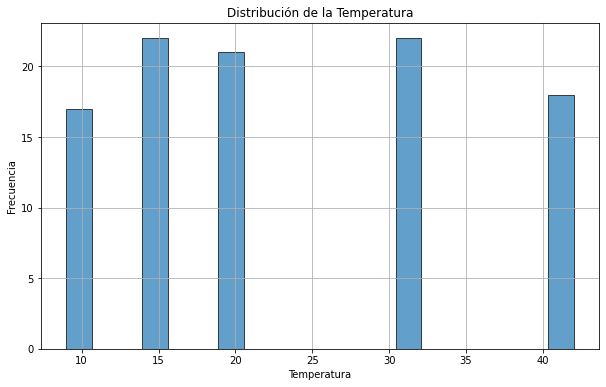

In [0]:
import matplotlib.pyplot as plt

# Convertir el DataFrame de Spark a un DataFrame de Pandas
df_silver_pd = df_silver.toPandas()

# Graficar la distribución de la temperatura
plt.figure(figsize=(10, 6))
plt.hist(df_silver_pd['temperatura'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribución de la Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

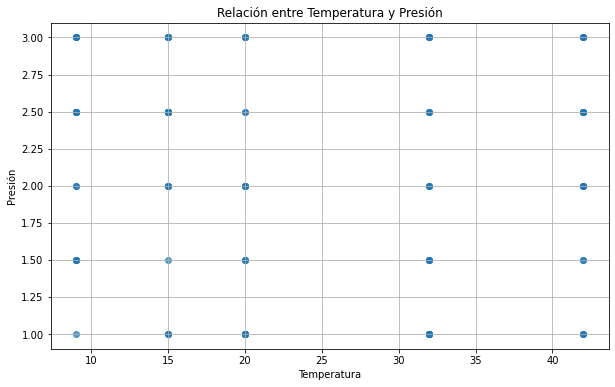

In [0]:
# Graficar la relación entre temperatura y presión
plt.figure(figsize=(10, 6))
plt.scatter(df_silver_pd['temperatura'], df_silver_pd['presion'], alpha=0.7)
plt.title('Relación entre Temperatura y Presión')
plt.xlabel('Temperatura')
plt.ylabel('Presión')
plt.grid(True)
plt.show()

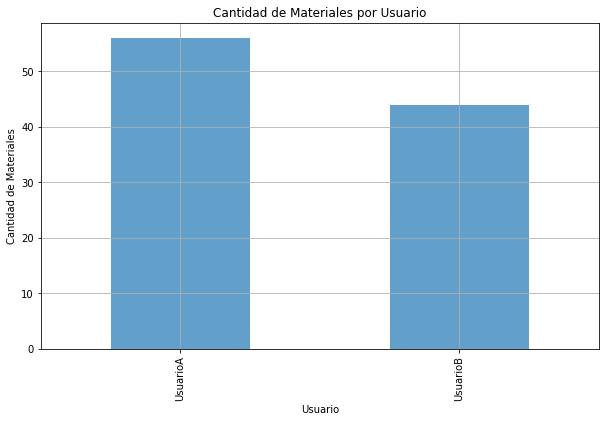

In [0]:
# Graficar la cantidad de materiales por usuario
plt.figure(figsize=(10, 6))
df_silver_pd['usuario'].value_counts().plot(kind='bar', alpha=0.7)
plt.title('Cantidad de Materiales por Usuario')
plt.xlabel('Usuario')
plt.ylabel('Cantidad de Materiales')
plt.grid(True)
plt.show()

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Crear el ensamblador de vectores
assembler = VectorAssembler(inputCols=["temperatura", "presion"], outputCol="features")
df_features = assembler.transform(df_silver)

# Crear el escalador estándar
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df_scaled = scaler.fit(df_features).transform(df_features)

# Mostrar las primeras filas del DataFrame escalado
df_scaled.show()

+-----------+--------------------+--------+-------------------+-------------------+--------------+-----------+-------+--------+-------------------------+----------+--------------------+
|id_material|              nombre| usuario|composicion_quimica|         aplicacion|fecha_creacion|temperatura|presion|duracion|clasificacion_temperatura|  features|     scaled_features|
+-----------+--------------------+--------+-------------------+-------------------+--------------+-----------+-------+--------+-------------------------+----------+--------------------+
|        152|Micro esferas de ...|UsuarioB|                (C)|        Conductores|    2024-02-24|         42|    2.5|      30|                     Alta|[42.0,2.5]|[3.64154245246185...|
|        975|Super tubos de plata|UsuarioA|             (SiO2)|Protectores solares|    2025-01-04|         20|    1.0|      50|                    Media|[20.0,1.0]|[1.73406783450564...|
|        898|Ultra esferas de ...|UsuarioB|                (C)|     An

In [0]:
from pyspark.sql.functions import col

df_con_nuevas_caracteristicas = df_silver.withColumn("eficiencia", col("temperatura") / col("duracion"))

In [0]:
from pyspark.sql.functions import col

# Crear el DataFrame con la nueva característica
df_con_nuevas_caracteristicas = df_silver.withColumn("eficiencia", col("temperatura") / col("duracion"))

# Crear una vista temporal llamada 'materiales_con_eficiencia'
df_con_nuevas_caracteristicas.createOrReplaceTempView("materiales_con_eficiencia")

In [0]:
%sql
Select * from materiales_con_eficiencia;

id_material,nombre,usuario,composicion_quimica,aplicacion,fecha_creacion,temperatura,presion,duracion,clasificacion_temperatura,eficiencia
152,Micro esferas de titanio,UsuarioB,(C),Conductores,2024-02-24,42,2.5,30,Alta,1.4
975,Super tubos de plata,UsuarioA,(SiO2),Protectores solares,2025-01-04,20,1.0,50,Media,0.4
898,Ultra esferas de cobre,UsuarioB,(C),Antimicrobiano,2024-11-06,32,1.5,20,Alta,1.6
480,Micro partículas de cobre,UsuarioB,(Sm2O3),Protectores solares,2024-12-23,15,3.0,30,Baja,0.5
247,Ultra láminas de zinc,UsuarioA,(ZnO),Protectores solares,2024-09-07,20,2.0,20,Media,1.0
846,Ultra esferas de oro,UsuarioA,(Sm2O3),Sensores,2024-12-22,20,1.5,40,Media,0.5
738,Nano láminas de plata,UsuarioA,(Ag),Protectores solares,2025-01-08,42,3.0,10,Alta,4.2
503,Ultra partículas de óxido de samario,UsuarioB,(Ti),Protectores solares,2024-03-08,9,2.0,10,Baja,0.9
676,Micro láminas de zinc,UsuarioA,(Ag),Antimicrobiano,2024-09-03,42,3.0,50,Alta,0.84
754,Super partículas de plata,UsuarioB,(Au),Conductores,2024-11-03,15,3.0,20,Baja,0.75


In [0]:
# Guardar el DataFrame en la carpeta gold
df_con_nuevas_caracteristicas.write.mode("overwrite").parquet("/mnt/gold/materiales_con_eficiencia.parquet")

print("El DataFrame se ha guardado correctamente en la carpeta gold.")

El DataFrame se ha guardado correctamente en la carpeta gold.
